In [1]:
from featureextraction import generate_embeddings
import h5py
import matplotlib.pyplot as plt
from models import get_baseline_convolutional_encoder, build_siamese_net
import numpy as np
import os
import random
from scipy.signal import decimate
from sklearn.manifold import TSNE
import tensorflow as tf
import yaml

In [2]:
# define species set
dataset_folds = [line.rstrip().split(',') for line in open('cv_folds.txt')]
species_set = dataset_folds[0]

# load parameters from config_file
config_file = 'siamrs12_4c_ew32_25.yaml'
models_path = 'models'
model_file = os.path.join(models_path, config_file)
with open(model_file) as cfile:
    config_params = yaml.safe_load(cfile)
eeg_epoch_width_in_s = config_params['epoch_width']
num_classes = config_params['num_classes']
decimate_factor = 4

In [3]:
# read EEG epochs - randomly sample num_samples from each class of each species
num_samples = 128
epochs_path = 'data/epochs_{}c'.format(num_classes)
file_template = '{}_BL5_ew{}.h5'
sw_s_epochs = []
ss_s_epochs = []
tw_s_epochs = []
ts_s_epochs = []
for species in species_set:
    print('Working on', species)
    file_path = os.path.join(epochs_path, file_template.format(species, eeg_epoch_width_in_s))
    with h5py.File(file_path, 'r') as file:
        if 'Sham' in species:
            sw_s_epochs.extend(random.sample(list(file['eeg']['wake']), num_samples))
            ss_s_epochs.extend(random.sample(list(file['eeg']['sleep']), num_samples))
        elif 'TBI' in species:
            tw_s_epochs.extend(random.sample(list(file['eeg']['wake']), num_samples))
            ts_s_epochs.extend(random.sample(list(file['eeg']['sleep']), num_samples))

Working on Sham104
Working on Sham105
Working on Sham107
Working on Sham108
Working on TBI103
Working on TBI104
Working on TBI106
Working on Sham102
Working on Sham103
Working on TBI101
Working on TBI102


In [4]:
# generate embeddings for EEG epochs
sw_epochs = generate_embeddings(decimate(sw_s_epochs, decimate_factor), model_file)
ss_epochs = generate_embeddings(decimate(ss_s_epochs, decimate_factor), model_file)
tw_epochs = generate_embeddings(decimate(tw_s_epochs, decimate_factor), model_file)
ts_epochs = generate_embeddings(decimate(ts_s_epochs, decimate_factor), model_file)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# reduce dimensionality using t-SNE
tsne = TSNE(perplexity=30, early_exaggeration=12.0, learning_rate=600.0, method='exact', init='pca', verbose=1,
            n_iter=40000)
sw_epochs = tsne.fit_transform(sw_epochs)
ss_epochs = tsne.fit_transform(ss_epochs)
tw_epochs = tsne.fit_transform(tw_epochs)
ts_epochs = tsne.fit_transform(ts_epochs)

<Figure size 1728x1728 with 0 Axes>

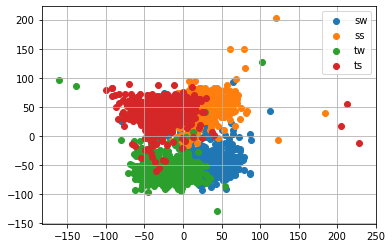

In [5]:
# plot embeddings
plt.figure(figsize=(24.0, 24.0))
fig, ax = plt.subplots()
ax.scatter(sw_epochs[:, 0], sw_epochs[:, 1], label='sw')
ax.scatter(ss_epochs[:, 0], ss_epochs[:, 1], label='ss')
ax.scatter(tw_epochs[:, 0], tw_epochs[:, 1], label='tw')
ax.scatter(ts_epochs[:, 0], ts_epochs[:, 1], label='ts')
ax.legend()
ax.grid(True)
plt.savefig('all.png')
plt.show()